# Train Based on clipping

In [1]:
import os
PROJECT = "RFCX"
EXP_NUM = "17"
EXP_TITLE = "SpecAugOnlyFreq"
EXP_NAME = "exp_" + EXP_NUM + "_" + EXP_TITLE
IS_WRITRE_LOG = True
os.environ['WANDB_NOTEBOOK_NAME'] = 'train_clip'
print('expname:' + EXP_NAME)

expname:exp_17_SpecAugOnlyFreq


## Library

In [2]:
# library import
import numpy as np
import pandas as pd
# import os
# import tqdm
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import random
import time
import math
import csv
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import logging
import librosa
import wandb
from time import sleep
from torch.nn import functional as F
from torch.optim import Adam, AdamW
from torchvision.models import resnet18, resnet34, resnet50
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataset import Subset
import torch.utils.data as torchdata
from torch.optim.lr_scheduler import CosineAnnealingLR, ReduceLROnPlateau
from transformers import get_linear_schedule_with_warmup
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold
from contextlib import contextmanager
from typing import Optional
from numpy.random import beta
from pathlib import Path
from fastprogress.fastprogress import master_bar, progress_bar
from torchviz import make_dot
from conformer import ConformerConvModule
from conformer import ConformerBlock
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from torch.utils.tensorboard import SummaryWriter
from efficientnet_pytorch import EfficientNet
from torchviz import make_dot
from torchsummary import summary
from torchlibrosa.augmentation import SpecAugmentation
import librosa.display
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# from IPython.core.display import display, HTML
# display(HTML("<style>.scroll_box { height:90em  !important; }</style>"))

## Configuration

In [3]:
# use GPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [4]:
# load weight
# model_efn = EfficientNet.from_pretrained('efficientnet-b7')
model_efn = EfficientNet.from_pretrained('efficientnet-b0')
# model_efn = EfficientNet.from_pretrained('efficientnet-b4')
model_efn.to(device); # calculate on cpu

Loaded pretrained weights for efficientnet-b0


In [5]:
# 5get length
class params:
    sr = 48000
    n_mels = 320
    fmin = 40
    fmax = sr // 2
    fft = 2048
    hop = 512
    clip_frame = 10 * 48000
    augnum = 100

def wav2mel(wavnp):
    melspec = librosa.feature.melspectrogram(
        wavnp, sr=params.sr, n_mels=params.n_mels, fmin=params.fmin, fmax=params.fmax, n_fft=params.fft, hop_length=params.hop, 
    )
    melspec = librosa.power_to_db(melspec).astype(np.float32)

    # normalize
    melspec = melspec - np.min(melspec)
    melspec = melspec / np.max(melspec)
    return melspec

wavnp = np.load(Path('../input//rfcx-species-audio-detection/train_mel/0.npy'))
print(wavnp.shape)
sample = wav2mel(wavnp[0: 10 * params.sr]) # 10s clipping

# sample data
# sample = torch.load(Path("e:/002_datasets/000_RFCX/train_mel_clip_aug/0_0.pt"))
# sample = torch.from_numpy(np.load(Path("../input/rfcx-species-audio-detection/train_mel/0.npy")))
# sample = torch.load(Path("../input/rfcx-species-audio-detection/train_mel_clip_aug/0_0.pt"))

# channel, seq, dim
print(sample.shape)
# print(sample[np.newaxis, :, :].shape)
clip_len = int(sample.shape[1])
clip_dim = int(sample.shape[0])
print(clip_len, clip_dim)

(931839,)
(320, 938)
938 320


In [6]:
# expeliment
clip = sample.T
print("clip", clip.shape)

# stacking
img = torch.from_numpy(np.array([
        [clip],[clip],[clip]
    ])).float().transpose(0, 1)
print("img", img.shape)

# encoding
enc = model_efn.extract_features(img.to(device))
print("enc", enc.shape)

enc = enc.detach().cpu()

# save
ch = enc.shape[1]
enc_len = enc.shape[2]
enc_dim = enc.shape[3]
print('ch, enc_len, enc_dim', ch, enc_len, enc_dim)

del enc

clip (938, 320)
img torch.Size([1, 3, 938, 320])
enc torch.Size([1, 1280, 30, 10])
ch, enc_len, enc_dim 1280 30 10


In [7]:
class dict2(dict): 
    def __init__(self, *args, **kwargs): 
        super().__init__(*args, **kwargs) 
        self.__dict__ = self 

In [8]:
config = dict2({
    "fft":                2048,
    "hop":                512,
    "sr":                 48000,
    "mel":                320,
    "SEED":               42,
    # "INPUT":              Path("../input/rfcx-species-audio-detection/train"),
    # "TRAIN_AUDIO_ROOT":   Path("../input/rfcx-species-audio-detection/train_mel_clip_aug/"),
    # "TEST_AUDIO_ROOT":    Path"../input/rfcx-species-audio-detection/train_mel_clip_aug/0_0.pt"),
    # "TRAIN_TP":           Path("../input/rfcx-species-audio-detection/train_tp.csv"),
    # "TRAIN_TP_MEL":       Path("../input/rfcx-species-audio-detection/train_tp_mel.csv"),
    # "SUB":                Path("../input/rfcx-species-audio-detection/sample_submission.csv"),
    "TEST_AUDIO_FLAC":    Path("../input/rfcx-species-audio-detection/test"),
    "TRAIN_AUDIO_ROOT":   Path("e:/002_datasets/000_RFCX/train_mel_clip_aug/"),
    "TEST_AUDIO_ROOT":    Path("../input/rfcx-species-audio-detection/test_mel"),
    "VALID_AUDIO_ROOT":   Path("e:/002_datasets/000_RFCX/valid_mel_clip/"),
    "TRAIN_TP":           Path("../input/rfcx-species-audio-detection/train_tp.csv"),
    "TRAIN_TP_CSV":       Path("../input/rfcx-species-audio-detection/train_tp_mel.csv"),
    "VALID_CSV":          Path("../input/rfcx-species-audio-detection/valid.csv"),
    "TEST_CSV":           Path("../input/rfcx-species-audio-detection/test.csv"),
    "SUB":                Path("../input/rfcx-species-audio-detection/sample_submission.csv"),
    # "DIM":                sample.shape[0],
    # "SEQ_LEN":            int(sample.shape[1] * 0.8),
    # "DIM":                dim,
    # "ENC_LEN":            seq_len,
    "CLIP_LEN":           clip_len,
    "CLIP_DIM":           clip_dim,
    "ENC_CH":             ch,
    "ENC_LEN":            enc_len,
    "ENC_DIM":            enc_dim,
    "KERNEL_SIZE":        3,
    "KERNEL_STRIDE":      1,
    "KERNEL_SIZE_SEQ":    3,
    "POOL_SIZE":          2,
    "POOL_STRIDE":        2,
    "NUM_BIRDS":          24,
    "N_FOLDS":            5,
    "BATCH_NUM":          30,
    "VALID_BATCH_NUM":    30,
    "EPOCH_NUM":          100,
    "DROPOUT":            0.35,
    "lr":                 0.001,
    "eta_min":            1e-5,
    "t_max":              10,
    "TEST_SIZE":          0.2,
    "MIXUP":              0.5,
    "MIXUP_PROB":         1.0,
    "SPEC_PROB":          0.7,
    "spec_time_w":        0,
    "spec_time_stripes":  0,
    "spec_freq_w":        32,
    "spec_freq_stripes":  3,
})


In [9]:
# seed
def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)  # type: ignore
    torch.backends.cudnn.deterministic = True  # type: ignore
    torch.backends.cudnn.benchmark = True  # type: ignore
set_seed(config.SEED)

In [10]:
spec_augmenter = SpecAugmentation(time_drop_width=config.spec_time_w, time_stripes_num=config.spec_time_stripes, 
            freq_drop_width=config.spec_freq_w, freq_stripes_num=config.spec_freq_stripes)

In [11]:
print(img.shape)
print(spec_augmenter(img).shape)

torch.Size([1, 3, 938, 320])
torch.Size([1, 3, 938, 320])


torch.Size([1, 3, 938, 320])


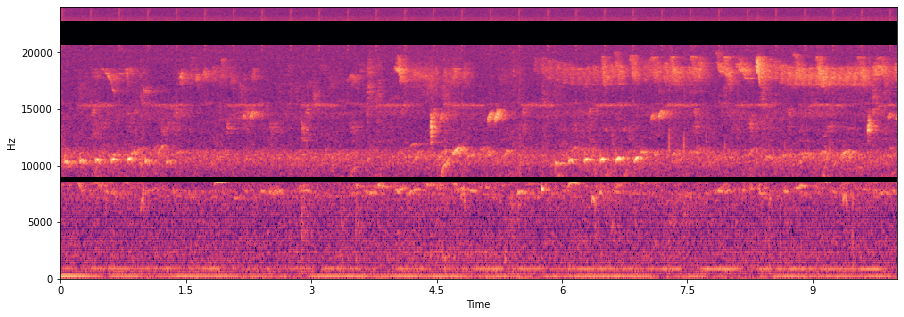

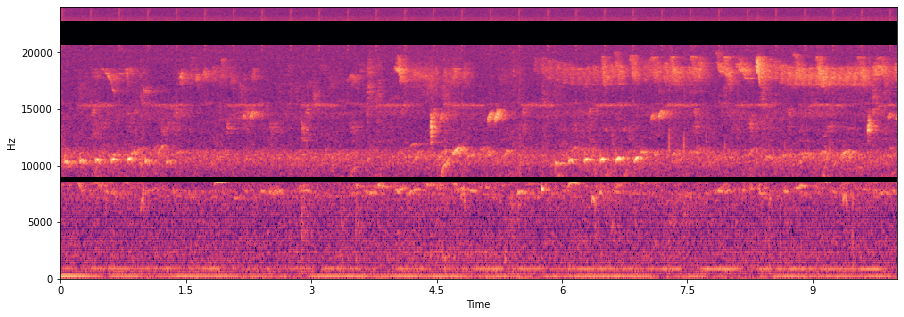

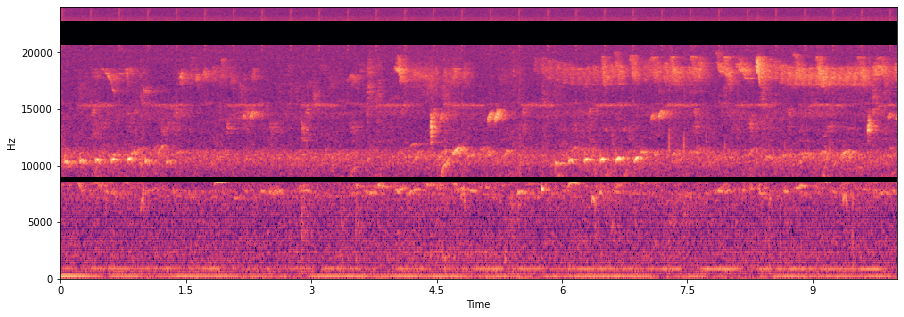

In [12]:
# stacking
img = torch.from_numpy(np.array([
        [clip],[clip],[clip]
    ])).float().transpose(0, 1)

print(img.shape)


s_img = spec_augmenter(img)

fig, ax = plt.subplots(figsize=(15, 5))
figure1ch = librosa.display.specshow(
    s_img.numpy()[0][0].T, 
    sr=48000,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)
fig, ax = plt.subplots(figsize=(15, 5))
figure2ch = librosa.display.specshow(
    s_img.numpy()[0][1].T, 
    sr=48000,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)
fig, ax = plt.subplots(figsize=(15, 5))
figure3ch = librosa.display.specshow(
    s_img.numpy()[0][2].T, 
    sr=48000,
    x_axis='time', 
    y_axis='linear', 
    ax=ax)


## Augment

In [13]:
# mixup
def mixup_data(x, y, alpha=1.0, use_cuda=True):

    '''Compute the mixup data. Return mixed inputs, pairs of targets, and lambda'''
    if alpha > 0.:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1.
    batch_size = x.size()[0]
    if use_cuda:
        index = torch.randperm(batch_size).cuda()
    else:
        index = torch.randperm(batch_size)
    # lam = max(lam, 1 - lam)
    mixed_x = lam * x + (1 - lam) * x[index,:]
    # mixed_y = lam * y + (1 - lam) * y[index]
    y_a, y_b = y, y[index]
    # return mixed_x, mixed_y
    return mixed_x, y_a, y_b, lam

# def mixup_criterion(y_a, y_b, lam):
#     return lambda criterion, pred: lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Transform

In [14]:
# transforms
train_transform = transforms.Compose([
    # transforms.RandomCrop((config.mel, config.CLIP_LEN)),
    # transforms.ToTensor()
])
valid_transform = transforms.Compose([
    # transforms.CenterCrop((config.mel, config.CLIP_LEN)),
    # transforms.ToTensor()
])
label_transform = transforms.Compose([
    # transforms.ToTensor()
])

## Dataset

In [15]:
# Data load
df_train_tp = pd.read_csv(config.TRAIN_TP_CSV)

# add column per birds and flogs
for col in range(24):
    df_train_tp[col] = 0

# one-hot encoding
for index, row in df_train_tp.iterrows():
    specId = row["species_id"]
    for col in range(24):
        if int(specId) == col:
            df_train_tp.iloc[index, df_train_tp.columns.get_loc(col)] = 1

# grouping
# df_train_tp = df_train_tp.groupby("recording_id", as_index=False).max()

# check
print(len(df_train_tp))
display(df_train_tp[df_train_tp["recording_id"] == "77299bde7"].head())


1216


,id,species_id,recording_id,t_min,t_maxs,offs,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
584,584,8,77299bde7,5.7227,9.8453,274689.6,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
585,585,21,77299bde7,42.3787,43.4720,427521.6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0


In [16]:
# display(df_train_tp[df_train_tp["recording_id"] == "00b404881"].head())
# df_train_tp_grouped = df_train_tp.groupby(["species_id", "recording_id"], as_index=False).max()
# display(df_train_tp_grouped[df_train_tp_grouped["recording_id"] == "00b404881"])

In [17]:
# load data
ids = []
specIds = []
record_ids = []
labels = []
offsets = []
for index, row in df_train_tp.iterrows():
    ids.append(row.values[0])
    specIds.append(row.values[1])
    record_ids.append(row.values[2])
    labels.append(row.values[6:30])
    offsets.append(row.values[5])

labels = np.array(labels).astype(float)

print('id', ids[584])
print('specid', specIds[584])
print('recid', record_ids[584])
print('label', labels[584])
print('label shape', labels[584].shape)
print('id len', len(ids))
print('offset', offsets[584])
print('offset', offsets[584] / params.sr)


id 584
specid 8
recid 77299bde7
label [0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
label shape (24,)
id len 1216
offset 274689.6
offset 5.7227


In [18]:
# class RainforestDatasets(torch.utils.data.Dataset):
#     def __init__(self, _transform, train = True):
#         self.transform = _transform
#         self.train = train

#         # data load
#         self.labelset = labels
#         self.dataset = []
#         for id in ids:
#             # read npy
#             melspec = torch.load(os.path.join(config.TRAIN_AUDIO_ROOT, str(id) + ".pt")) # (dim, seq_len)
#             # melspec = torch.from_numpy(melspec)
#             # melspec = melspec.unsqueeze(0) # add channel for first convolution
#             # melspec = melspec[np.newaxis, :, :] # add channel for first convolution
#             self.dataset.append(melspec)

#         self.dataset = np.array(self.dataset).astype(float)
#         self.datanum = len(self.dataset)
        

#     def __len__(self):
#         return self.datanum

#     def __getitem__(self, idx):
#         # get data
#         out_label = self.labelset[idx]
#         out_data = self.dataset[idx]

#         # to tensor
#         out_label = torch.from_numpy(out_label).float()
#         # out_data = torch.from_numpy(out_data).float()
        
#         # transform label
#         # out_data = self.transform(out_data)
#         # out_label = label_transform(out_label)

#         # out_data = out_data.transpose(0, 1) # (dim, seq_len) => (seq_len, dim)
#         # out_data = out_data.unsqueeze(0) # add channel for first convolution (seq_len, dim) => (c, seq_len, dim)
#         # out_data = torch.stack([out_data, out_data, out_data]) # add channel for first convolution (seq_len, dim) => (c, seq_len, dim)
#         # print(type(out_data))
#         # print(type(np.array(out_label)))
#         # print(out_data.shape)

#         # # encoding on cpu(Its important for reduce usage of gpu memory)
#         # out_data = out_data.unsqueeze(0) # add fake batch
#         # out_data = model_efn.extract_features(out_data)
#         # out_data = out_data[0]

#         return out_data, out_label

In [19]:
# in: idx, out: batch(valid), label(s)
class RainforestTrainDatasets(torch.utils.data.Dataset):
    def __init__(self):
        self.labels = labels
        self.ids = ids     
        self.datanum = len(labels)   
        self.record_ids = record_ids
        self.offsets = offsets

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        # get data
        out_label = self.labels[idx]

        # random crop
        randomCropOffset = int((int(np.random.rand() * self.offsets[idx])))

        # load wav
        wavnp = np.load(Path('../input//rfcx-species-audio-detection/train_mel/' + str(self.ids[idx]) + '.npy'))
        if randomCropOffset >= 0:
            
            wavnp = wavnp[0 + randomCropOffset: (10 * params.sr) + randomCropOffset]
        else:
            wavnp = wavnp[len(wavnp) - (10 * params.sr) + randomCropOffset : len(wavnp) + randomCropOffset]
        wavnp = wav2mel(wavnp) # 10s clipping

        # dim, seq_len => seq_len, dim
        wavnp = wavnp.T

        # add channel
        wavnp = np.stack([wavnp, wavnp, wavnp])

        # to Tensor
        wavTensor = torch.from_numpy(wavnp)

        return wavTensor, out_label

In [20]:
# in: idx, out: batch(valid), label(s)
class RainforestValidDatasets(torch.utils.data.Dataset):
    def __init__(self):
        self.labels = labels
        self.ids = ids     
        self.datanum = len(labels)   

    def __len__(self):
        return self.datanum

    def __getitem__(self, idx):
        # get data
        out_label = self.labels[idx]

        outdatas = []

        #TODO: 11 is magic number, due to change it to conf
        for i in range(11):
            if i % 2 == 0:
                # load melspec(dim, seq_len)
                melspec =  np.load(os.path.join(config.VALID_AUDIO_ROOT, str(self.ids[idx]) + "_" + str(i) + ".npy"))
                # add channel
                melspec = np.stack([melspec.T, melspec.T, melspec.T])
                outdatas.append(melspec)

        # list 2 tochtensor(batch, channel, seq_len, dim)
        outdatas = torch.from_numpy(np.array(outdatas))

        return outdatas, out_label

## Check Data

In [22]:
# # ds train
# import librosa.display
# ds = RainforestTrainDatasets(train_transform)
# loader = DataLoader(ds)

# # check aug
# for x, y in loader:
#     a = 1

# fig, ax = plt.subplots(figsize=(15, 5))
# ax.set(title='train random crop')
# img = librosa.display.specshow(
#     x.numpy()[0][0].T, 
#     sr=48000,
#     x_axis='time', 
#     y_axis='linear', 
#     ax=ax)


# ds = RainforestDatasets(valid_transform)
# loader = DataLoader(ds)

# # check aug
# for x, y in loader:
#     a = 1

# fig, ax = plt.subplots(figsize=(15, 5))
# ax.set(title='validation center crop')
# img = librosa.display.specshow(
#     x.numpy()[0][0].T, 
#     sr=48000,
#     x_axis='time', 
#     y_axis='linear', 
#     ax=ax)

# # ax.set(title=f'Mel-frequency spectrogram of {row["recording_id"]}')
# # fig.colorbar(img, ax=ax, format="%+2.f dB")
# print(x.numpy()[0][0].T.shape)

# melspec = np.load(os.path.join(config.TRAIN_AUDIO_ROOT, str(1215) + ".npy"))
# fig, ax = plt.subplots(figsize=(15, 5))
# img = librosa.display.specshow(
#     melspec, 
#     sr=48000,
#     x_axis='time', 
#     y_axis='linear', 
#     ax=ax)
# print(melspec.shape)

## Modeling

In [23]:
# Conformer
# https://arxiv.org/abs/2005.08100
class RainforestTransformer(nn.Module):
    def __init__(self):
        super(RainforestTransformer, self).__init__()         

        self.encoding = model_efn
        # self.pointwise = nn.Conv2d(config.ENC_CH, 1, (1, 1))
        self.conv = nn.Conv2d(config.ENC_CH, 1, (config.KERNEL_SIZE_SEQ, config.KERNEL_SIZE), stride=config.KERNEL_STRIDE)
        self.linear = nn.Linear(int((((((config.ENC_DIM - config.KERNEL_SIZE) / config.KERNEL_STRIDE) + 1) - config.POOL_SIZE) / config.POOL_STRIDE) + 1), config.ENC_DIM)
        self.dropout = nn.Dropout(config.DROPOUT)
        
        self.conformerblock = ConformerBlock(
            dim = config.ENC_DIM,
            dim_head = 64,
            heads = 8,
            ff_mult = 4,
            conv_expansion_factor = 2,
            conv_kernel_size = 31,
            attn_dropout = config.DROPOUT,
            ff_dropout = config.DROPOUT,
            conv_dropout = config.DROPOUT
        )
        self.conformerblock2 = ConformerBlock(
            dim = config.ENC_DIM,
            dim_head = 64,
            heads = 8,
            ff_mult = 4,
            conv_expansion_factor = 2,
            conv_kernel_size = 31,
            attn_dropout = config.DROPOUT,
            ff_dropout = config.DROPOUT,
            conv_dropout = config.DROPOUT
        )

        self.decoder = nn.Linear(1 * int((((((config.ENC_LEN - config.KERNEL_SIZE_SEQ) / config.KERNEL_STRIDE) + 1) -  config.POOL_SIZE) / config.POOL_STRIDE) + 1) * config.ENC_DIM, config.NUM_BIRDS)

        # devided by stride
    
    # x: (b, c, seqlen, dim)
    def forward(self, x):
        # (b, c, seqlen, dim) => (b, c, seqlen, dim)
        x = self.encoding.extract_features(x)
        # enc = self.pointwise(enc)

        # (b, c, seqlen, dim) <= encoded matrix
        # point-wise convokution for convolution channel.
        h = F.relu(self.conv(x))
        h = F.max_pool2d(h, config.POOL_SIZE, stride=config.POOL_STRIDE)
        h = self.linear(h)
        h = h.transpose(0, 1)[0] # transpose batch and channel to delet channel dimension
        h = self.conformerblock(h)
        h = self.conformerblock2(h)
        # h = self.conformerblock3(h)
        # h = self.conformerblock4(h)
        # h = self.conformerblock5(h)
        # h = self.conformerblock6(h)
        h = h.view(-1, 1 * int((((((config.ENC_LEN - config.KERNEL_SIZE_SEQ) / config.KERNEL_STRIDE) + 1) -  config.POOL_SIZE) / config.POOL_STRIDE) + 1) * config.ENC_DIM)
        out = self.decoder(h)
        return out

## Visualize Model

In [24]:
# # dummy = torch.stack([clip, clip, clip]).unsqueeze(0)
# model = RainforestTransformer()
# y = model(sample.unsqueeze(0))
# make_dot(y,params=dict(model.named_parameters()))

## Preserve Memory

In [25]:
# # delete unusual var
del sample
# del model_efn
# del y

## Metric

In [26]:
# from official code https://colab.research.google.com/drive/1AgPdhSp7ttY18O3fEoHOQKlt_3HJDLi8#scrollTo=cRCaCIb9oguU
def _one_sample_positive_class_precisions(scores, truth):
    """Calculate precisions for each true class for a single sample.

    Args:
      scores: np.array of (num_classes,) giving the individual classifier scores.
      truth: np.array of (num_classes,) bools indicating which classes are true.

    Returns:
      pos_class_indices: np.array of indices of the true classes for this sample.
      pos_class_precisions: np.array of precisions corresponding to each of those
        classes.
    """
    num_classes = scores.shape[0]
    pos_class_indices = np.flatnonzero(truth > 0)
    # Only calculate precisions if there are some true classes.
    if not len(pos_class_indices):
        return pos_class_indices, np.zeros(0)
    # Retrieval list of classes for this sample.
    retrieved_classes = np.argsort(scores)[::-1]
    # class_rankings[top_scoring_class_index] == 0 etc.
    class_rankings = np.zeros(num_classes, dtype=np.int)
    class_rankings[retrieved_classes] = range(num_classes)
    # Which of these is a true label?
    retrieved_class_true = np.zeros(num_classes, dtype=np.bool)
    retrieved_class_true[class_rankings[pos_class_indices]] = True
    # Num hits for every truncated retrieval list.
    retrieved_cumulative_hits = np.cumsum(retrieved_class_true)
    # Precision of retrieval list truncated at each hit, in order of pos_labels.
    precision_at_hits = (
            retrieved_cumulative_hits[class_rankings[pos_class_indices]] /
            (1 + class_rankings[pos_class_indices].astype(np.float)))
    return pos_class_indices, precision_at_hits


def calculate_per_class_lwlrap(truth, scores):
    """Calculate label-weighted label-ranking average precision.

    Arguments:
      truth: np.array of (num_samples, num_classes) giving boolean ground-truth
        of presence of that class in that sample.
      scores: np.array of (num_samples, num_classes) giving the classifier-under-
        test's real-valued score for each class for each sample.

    Returns:
      per_class_lwlrap: np.array of (num_classes,) giving the lwlrap for each
        class.
      weight_per_class: np.array of (num_classes,) giving the prior of each
        class within the truth labels.  Then the overall unbalanced lwlrap is
        simply np.sum(per_class_lwlrap * weight_per_class)
    """
    assert truth.shape == scores.shape
    num_samples, num_classes = scores.shape
    # Space to store a distinct precision value for each class on each sample.
    # Only the classes that are true for each sample will be filled in.
    precisions_for_samples_by_classes = np.zeros((num_samples, num_classes))
    for sample_num in range(num_samples):
        pos_class_indices, precision_at_hits = (
            _one_sample_positive_class_precisions(scores[sample_num, :],
                                                  truth[sample_num, :]))
        precisions_for_samples_by_classes[sample_num, pos_class_indices] = (
            precision_at_hits)
    labels_per_class = np.sum(truth > 0, axis=0)
    weight_per_class = labels_per_class / float(np.sum(labels_per_class))
    # Form average of each column, i.e. all the precisions assigned to labels in
    # a particular class.
    per_class_lwlrap = (np.sum(precisions_for_samples_by_classes, axis=0) /
                        np.maximum(1, labels_per_class))
    # overall_lwlrap = simple average of all the actual per-class, per-sample precisions
    #                = np.sum(precisions_for_samples_by_classes) / np.sum(precisions_for_samples_by_classes > 0)
    #           also = weighted mean of per-class lwlraps, weighted by class label prior across samples
    #                = np.sum(per_class_lwlrap * weight_per_class)
    return per_class_lwlrap, weight_per_class

In [27]:
allclip = np.stack([
    np.zeros([3,10,2]),
    np.ones([3,10,2]),
    np.zeros([3,10,2]),
    np.ones([3,10,2]),
    np.zeros([3,10,2]),
])
# div, c, seq_len, dim
print(allclip.shape)

# b, d, c, s, d
batch = np.stack([allclip, allclip, allclip, allclip])
print(batch.shape)

# reshape
print('loop all divnum')
for i in range(batch.shape[1]):
    print(batch[:, i, :, :].shape)
    # print(batch[])
    print(batch[:, i, :, :].sum())
    # 4 * 3 * 10 * 2


(5, 3, 10, 2)
(4, 5, 3, 10, 2)
loop all divnum
(4, 3, 10, 2)
0.0
(4, 3, 10, 2)
240.0
(4, 3, 10, 2)
0.0
(4, 3, 10, 2)
240.0
(4, 3, 10, 2)
0.0


In [28]:
a = np.random.randint(0, 10, (2,4,3))
print(a)

print(np.max(a, axis=0))
# print(np.max(a, axis=1))

# print(np.max(a, axis=2))

[[[6 3 7]
  [4 6 9]
  [2 6 7]
  [4 3 7]]

 [[7 2 5]
  [4 1 7]
  [5 1 4]
  [0 9 5]]]
[[7 3 7]
 [4 6 9]
 [5 6 7]
 [4 9 7]]


In [29]:
torch.max(torch.Tensor([0,1,2]), dim=0).values

tensor(2.)

## Train

In [30]:
def train():

    # Stratified k-fold
    skf = StratifiedKFold(n_splits=config.N_FOLDS, shuffle=True, random_state=config.SEED)
    # msss = MultilabelStratifiedShuffleSplit(n_splits=config.N_FOLDS, test_size=config.TEST_SIZE, random_state=config.SEED)

    # Read dataset
    train_datasets = RainforestTrainDatasets()
    # valid_datasets = RainforestDatasets(_transform=valid_transform)

    # valid dataset dosen't need to transform(already be croped)
    valid_datasets = RainforestValidDatasets()

    best_epochs = []
    best_lwlraps = []

    # tensorboard
    # if IS_WRITRE_LOG:
    #     writer = SummaryWriter(log_dir="./logs/" + EXP_NAME)

    # k-fold
    # for kfoldidx, (train_index, valid_index) in enumerate(msss.split(labels, labels)):
    for kfoldidx, (train_index, valid_index) in enumerate(skf.split(specIds, specIds)):

        # model 
        model = RainforestTransformer()
        model.to(device)

        # init
        best_lwlrap = 0.
        best_epoch = 0

        if IS_WRITRE_LOG:
            run = wandb.init(config=config, project=PROJECT, group=EXP_NAME, reinit=True)
            print('wandb init')
            wandb.run.name = EXP_NAME + '-fold-' + str(kfoldidx)
            wandb.run.save()
            wandb.watch(model)

        # criterion
        print('wandb init2')
        criterion = nn.BCEWithLogitsLoss().cuda()

        # optimizer
        optimizer = Adam(params=model.parameters(), lr=config.lr, amsgrad=False)
        # print(optimizer)

        # train
        train_subset = Subset(train_datasets, train_index)
        train_loader = DataLoader(train_subset, batch_size=config.BATCH_NUM, shuffle=True)

        # validation
        valid_subset = Subset(valid_datasets, valid_index)
        valid_loader = DataLoader(valid_subset, batch_size=config.VALID_BATCH_NUM, shuffle=False)

        # scheduler
        # scheduler = CosineAnnealingLR(optimizer, T_max=config.t_max, eta_min=config.eta_min)
        num_train_steps = int(len(train_loader) * config.EPOCH_NUM)
        num_warmup_steps = int(0.1 * config.EPOCH_NUM * len(train_loader))
        scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=num_train_steps)

        # epoch
        mb = master_bar(range(config.EPOCH_NUM))
        mb.names = ['avg_loss', 'avg_val_loss', 'lwlrap']

        # Epoch
        for epoch in mb:

            # start time
            start_time = time.time()

            # train mode
            model.train()

            # init loss
            avg_loss = 0.

            # batch training
            train_batch_preds = []
            train_batch_labels = []
            for x_batch, y_batch in progress_bar(train_loader, parent=mb):

                # MixUp
                dice = np.random.rand(1)
                if dice < config.MIXUP_PROB:
                    # mixup
                    x_batch, y_batch, y_batch_b, lam = mixup_data(x_batch, y_batch, alpha=config.MIXUP, use_cuda=True)

                # spec Aug
                dice_s = np.random.rand(1)
                if dice_s < config.SPEC_PROB:
                    # specaug
                    x_batch = spec_augmenter(x_batch)                

                # forward
                preds = model(x_batch.to(device))

                if dice < config.MIXUP_PROB:
                    loss = mixup_criterion(criterion, preds, y_batch.to(device), y_batch_b.to(device), lam)
                else:
                    loss = criterion(preds, y_batch.to(device)) # It dosen't need Sigmoid, because BCE includes sigmoid function.

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                avg_loss += loss.item() / len(train_loader)

                del loss

                # add preds
                train_batch_preds.extend(torch.sigmoid(preds).detach().cpu().numpy().tolist())
                train_batch_labels.extend(y_batch.detach().cpu().numpy().tolist())

            # calc score
            score, weight = calculate_per_class_lwlrap(np.array(train_batch_labels), np.array(train_batch_preds))
            train_lwlrap = (score * weight).sum()

            # last_preds =  np.array(train_batch_preds)
            # last_labels = np.array(train_batch_labels)

            # validation mode
            model.eval()
            valid_batch_preds = []
            valid_batch_labels = []
            # valid_preds = np.zeros((len(valid_index), config.NUM_BIRDS))
            avg_val_loss = 0.

            # validation
            # for x_batch, y_batch in progress_bar(train_loader, parent=mb):
            for i, (x_batch, y_batch) in enumerate(valid_loader):
                # !!!caution!!!
                # x_batch's shape (batch, devide length(i.e. 51), channel, seq_len, dim)
                # extract column

                wholeclip_preds = []
            
                for divnum in range(x_batch.shape[1]):
                    x_batch_divided = x_batch[:, divnum, :, :]
                    preds = model(x_batch_divided.to(device)).detach() # (batch, species_id)
                    wholeclip_preds.append(preds.cpu().numpy().tolist()) # (divnum, batch, species_id)

                # get max via divnum
                # (batch, preds_dimention)
                preds = torch.max(torch.from_numpy(np.array(wholeclip_preds)).float(), dim=0).values

                # preds = model(x_batch.to(device)).detach()
                loss = criterion(preds.to(device), y_batch.to(device))

                preds = torch.sigmoid(preds)
                # valid_preds[i * config.VALID_BATCH_NUM: (i+1) * config.VALID_BATCH_NUM] = preds.cpu().numpy()
                avg_val_loss += loss.item() / len(valid_loader)

                valid_batch_preds.extend(preds.detach().cpu().numpy().tolist())
                valid_batch_labels.extend(y_batch.detach().cpu().tolist())

            # calc score
            # score, weight = calculate_per_class_lwlrap(labels[valid_index], valid_preds)
            score, weight = calculate_per_class_lwlrap(np.array(valid_batch_labels), np.array(valid_batch_preds))
            lwlrap = (score * weight).sum()

            # update lr
            scheduler.step()

            # tensorboard
            if IS_WRITRE_LOG:
                # tensorboard
                # writer.add_scalar("train_loss/fold-" + str(kfoldidx), avg_loss, epoch)
                # writer.add_scalar("valid_loss/fold-" + str(kfoldidx), avg_val_loss, epoch)
                # writer.add_scalar("train_lwlrap/fold-" + str(kfoldidx), train_lwlrap, epoch)
                # writer.add_scalar("valid_lwlrap/fold-" + str(kfoldidx), lwlrap, epoch)

                wandb.log({
                    'loss/train': avg_loss,
                    'lwlrap/train': train_lwlrap,
                    'loss/validation': avg_val_loss,
                    'lwlrap/validation': lwlrap,
                    'epoch': epoch
                })


            if (epoch + 1) % 5 == 0:
                elapsed = time.time() - start_time
                mb.write(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f} train_lwlrap: {train_lwlrap:.6f}  val_lwlrap: {lwlrap:.6f}  time: {elapsed:.0f}s')
        
            if lwlrap > best_lwlrap and epoch > 50:
                best_epoch = epoch + 1
                best_lwlrap = lwlrap
                # torch.save(model.state_dict(), 'weight_best_' + str(EXP_NUM) + '_fold' + str(kfoldidx) +'.pt')
                torch.save(model.state_dict(), 'weight_best_fold' + str(kfoldidx) +'.pt')
            
        best_epochs.append(best_epoch)
        best_lwlraps.append(best_lwlrap)

        # return last_preds, last_labels

        if IS_WRITRE_LOG:
            run.finish()

    # if IS_WRITRE_LOG:
    #     writer.close()
    
    return {
        'best_epoch': best_epochs,
        'best_lwlrap': best_lwlraps,
    }




In [31]:
result = train()
print(result)

wandb: Currently logged in as: tatsuya-takahashi (use `wandb login --relogin` to force relogin)


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
wandb init
wandb init2


loss/train,0.09114
lwlrap/train,0.60092
loss/validation,0.09912
lwlrap/validation,0.77701
epoch,99
_step,99
_runtime,8660
_timestamp,1612665104


loss/train,██▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁
lwlrap/train,▁▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▃▃▄▅▅▄▅▅▆▄▆▆▆▆▅▇█
loss/validation,██▆▅▄▄▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lwlrap/validation,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▃▃▄▄▄▄▄▄▅▅▅▆▆▆▆▇▇▇▇▇███
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
wandb init
wandb init2


loss/train,0.07179
lwlrap/train,0.61875
loss/validation,0.09967
lwlrap/validation,0.77089
epoch,99
_step,99
_runtime,8516
_timestamp,1612673629


loss/train,██▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lwlrap/train,▁▁▁▁▁▁▁▁▁▁▂▂▂▃▄▄▅▄▆▅▆▅▇▅▇▆▇▆██▆▇▇▇█▆▇▄██
loss/validation,█▇▅▄▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lwlrap/validation,▁▁▁▁▁▁▂▂▂▂▂▃▄▄▅▆▆▇▇▇▇▇█████████████████▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
wandb init
wandb init2


loss/train,0.06999
lwlrap/train,0.52494
loss/validation,0.10229
lwlrap/validation,0.83538
epoch,99
_step,99
_runtime,7952
_timestamp,1612681590


loss/train,█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lwlrap/train,▁▁▁▁▁▁▂▂▂▂▃▃▅▅▅▇▇▆▅▆▇▇▆█▇▆▆▆▇▆▇▇██▆▅▇▇█▆
loss/validation,█▇▆▅▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lwlrap/validation,▁▁▁▂▂▂▂▂▃▄▆▇███████████████▇██▇▇█▇▇▇▇▇▇▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
_runtime,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███
_timestamp,▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇███


wandb: WARNING Calling run.save without any arguments is deprecated.Changes to attributes are automatically persisted.
wandb init
wandb init2


KeyboardInterrupt: 

## Submission

In [ ]:
# prediction
models = []
for fold in range(config.N_FOLDS):
    # load network
    model = RainforestTransformer()
    # torch.save(model.state_dict(), 'weight_best_' + str(EXP_NUM) + '_fold' + str(kfoldidx) +'.pt')
    model.load_state_dict(torch.load('weight_best_fold' + str(fold) +'.pt'))
    # print('weight_best_' + str(EXP_NUM) + '_fold' + str(fold) +'.pt')
    # model.load_state_dict(torch.load('weight_best_' + str(EXP_NUM) + '_fold' + str(fold) +'.pt'))
    model.to(device)
    model.eval()
    models.append(model)

In [ ]:
# write submission
with open('submission_' + EXP_NAME + '.csv', 'w', newline='') as csvfile:
    print('submission_' + EXP_NAME + '.csv')
    submission_writer = csv.writer(csvfile, delimiter=',')
    submission_writer.writerow(['recording_id','s0','s1','s2','s3','s4','s5','s6','s7','s8','s9','s10','s11',
                               's12','s13','s14','s15','s16','s17','s18','s19','s20','s21','s22','s23'])
    
    test_files = os.listdir(config.TEST_AUDIO_FLAC)
    
    # Every test file is split on several chunks and prediction is made for each chunk
    for i in tqdm(range(0, len(test_files))):
    # for i in range(0, 1):
        # read data
        # X_test = torch.from_numpy(np.load(os.path.join(config.TEST_AUDIO_ROOT, test_files[i])))

        # (dim, seq_len)        
        # X_test = np.load(os.path.join(config.TEST_AUDIO_ROOT, test_files[i]))
        X_test_batch = []

        # muptiply number
        # TODO: 51 is magic number. You have to rewrite 51 to vars.
        dev_num = 51

        # Cutting!
        for idx in range(dev_num):
            recId =  test_files[i].split('.')[0]
            X_test = np.load(os.path.join(config.TEST_AUDIO_ROOT, recId + '_' + str(idx) + '.npy')) # (DIM, seq_len)
            X_test_clip = X_test.T # (seq_len, DIM)
            # X_test_clip = X_test_clip[np.newaxis, :, :] # add fake channel
            X_test_clip = np.stack([X_test_clip, X_test_clip, X_test_clip]) # expand to channel
            X_test_batch.append(X_test_clip.tolist())

        # to_tensor
        X_test_batch = torch.from_numpy(np.array(X_test_batch)).float() # (batch, channel, seq_len, dim)
        X_test_batch = X_test_batch.to(device)

        # predict
        output_list = []
        for m in models:
            outputs = []
            for x_b in X_test_batch:
                output = m(torch.stack([x_b]))
                outputs.append(output[0].cpu().detach().numpy().tolist())
            # outputs S= m(X_test_batch)
            maxed_output = torch.max(torch.from_numpy(np.array(outputs)).float(), dim=0) # max about batch clips
            # maxed_output = torch.max(outputs, dim=0) # max about batch clips
            maxed_output = maxed_output.values.cpu().detach()
            output_list.append(maxed_output)
        avg_maxed_output = torch.mean(torch.stack(output_list), dim=0)
        
        file_id = str.split(test_files[i], '.')[0]
        write_array = [file_id]
        
#         for out in maxed_output:
        for out in avg_maxed_output:
            write_array.append(out.item())
    
        submission_writer.writerow(write_array)
        
        if i % 100 == 0 and i > 0:
            print('Predicted for ' + str(i) + ' of ' + str(len(test_files) + 1) + ' files')

        
print('finished!')